<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining (QBUS6810)</h1>
<h2 align="center" style="margin-top:10px">Tutorial 3: Regression modelling</h2>
<br>


In this tutorial we will put the linear regression modelling tools from Lecture 2 into practice.

<a href="#Data">Data</a> <br>
<a href="#Training-and-Test-Sets">Training and Test Sets</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Linear-Regression">Linear Regression</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings throughout. We will load new packages and functions in context to make clear what we are using them for. 

<hr style="height:2px;border-width:0;color:black;background-color:black">

So this week we are going to start builing our first model, scary! Now we will be using `statsmodel` this week, but later on in the course we will be using something different. So pay attention today, but not too much attention.

Once again, though, the main focus on this tutorial will be on understanding how to read the code. Then once we understand how to read it, programming it should be easy. 

Its kind of like learning a new subject - whenever you start learning a new subject there is going to be a certain language/words they use that you don't quite understand right now. But as you start understand the words they use, and how they use it, the subject becomes very easy. So I'm trying to teach this now.

Now there will probably be parts in this notebook where you would ask 

    'How would I even begin to know how to do this?' - You

Fortunately, the answers usually will be given in the notebooks. Meaning that any problem you will come across when doing your assignments, can usualy be solved by looking at the code of tutorials. So when you build a linear regression model, or KNN, you can just copy and paste the code in the Notebooks.

As such, I place an heavy emphasis on knowing how to read the code because most of the time all you will need is to copy and paste code. You will rarely have to any typing. So really the more difficult part is to know what a peice of code is doing, so you can copy and paste it in your own code.

<hr style="height:2px;border-width:0;color:black;background-color:red">

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, typically you would leave them on

In [2]:
# Plot settings
sns.set_context('notebook') # optimise figures for notebook display
# sns.set_style('ticks') # set default plot style
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (9, 6)

## Data

The <TT>Employees.csv</TT> file records data about the employees of a company. The dataset is from [Business Analytics for Managers](http://www.springer.com/us/book/9781461404057) by Wolfgang Jank.  In this problem, the managers are concerned with the issue of equal pay in the company. If we compare male and female employees with the same level of experience, are they paid the same on average?

In recent years, workforce, [HR](https://www-01.ibm.com/software/analytics/solutions/operational-analytics/hr-analytics/), and [people analytics](http://knowledge.wharton.upenn.edu/article/open-sourcing-googles-hr-secrets/) have emerged as terms for the practice of data-driven human capital management. 

In [6]:
data = pd.read_csv('Employees.csv')
data.head()

,Gender,Experience,Salary
0,Female,15,78200
1,Female,12,66400
2,Female,15,61200
3,Female,3,61000
4,Female,4,60000


In [7]:
data.tail()

,Gender,Experience,Salary
203,Male,39,148000
204,Male,34,190000
205,Male,36,194000
206,Male,32,176000
207,Male,35,188000


## Training and Test Sets

We use the Scikit-Learn train_test_split method to split the data into training and test sets.

Below, we specify that the training set will contain 70% of the data. The random state parameter is an arbitrary number. By setting a specific value for the random state we ensure that we get the same training and test sets if we run the analysis again, even though the split is random.

<hr style="height:2px;border-width:0;color:black;background-color:black">
Our first big piece of code is this

In [9]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(data.index, train_size=0.7, random_state=10)

So the first thing we want to look at is what ever is on the RIGHT side of the `=` sign, because this is what is going to be computed by the computer.

`train_test_split(data.index, train_size=0.7, random_state=10)`

So, first recognise that this is a function, not a dataframe. We know this because of the use of `(` not `[`. The square brackets are used when you want to access locations of a dataset, but `(` are used when you are giving inputs to a function.

So regardless, we have a function named `train_test_split` and we are giving it the inputs `data.index, train_size=0.7, random_state=10`. Once again, we will go one by one. 

### `train_test_split`
One of the biggest indications of what the function will do is by the name of the function. So reading the name, the only way to interpret it is that it will split something up into the train and test set. Simple! 

To double check our guess,

In [10]:
train_test_split?

### `data.index`
The `list` is there for technical reasons, but no surprise, `data.index` is simply the index names of the data.

In [7]:
list(data.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


### `train_size=0.7`
Simple, the training size is just 70% of the dataset


### `random_state=10`
This requires a bit more computing knowledge to understand this. The idea is that it is almost impossible for a computer to give random numbers. So instead, we settle on algorithms who's outputs look random, otherwise known as Pseudo-Random Numbers.

The key idea is that these algorithms look random, but are completely predictable. We can predict them by setting their `random_state` or `seed`. To see this, let us generate 10 random numbers

In [14]:
import numpy as np
np.random.randint(0, 10, size=(10,))  # Generate random numbers of size 10

array([0, 2, 5, 4, 7, 2, 0, 2, 4, 1])

But now I'm going to generate 10 more random numbers and I can predict the exact numbers they will be

    [9, 4, 0, 1, 9, 0, 1, 8, 9, 0]

In [18]:
np.random.seed(10)
np.random.randint(0, 10, size=(10,))

array([9, 4, 0, 1, 9, 0, 1, 8, 9, 0])

Interesting, eventhough I'm telling the computer to generate me random numbers (`np.random.randint(0, 10, size=(10,))`) I am actually able to predict it 100% correct. The reason why I was able to predict it was because I `seeded` the random number generation (`np.random.seed(10)`). 

But if I don't type the seed, I no longer am able to guess the numbers

In [24]:
np.random.randint(0, 10, size=(10,))

array([6, 5, 6, 0, 0, 6, 9, 1, 8, 9])

By the way, this is how people can do stuff like the video below. They first need to figure out what algorithm Google is using, then they figure which seed they start of at.

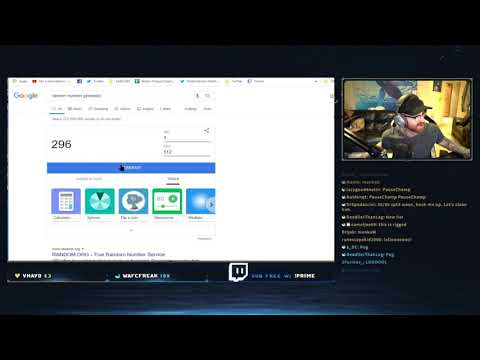

In [11]:
from IPython.display import YouTubeVideo

YouTubeVideo('h9i3oCarI7g', width=720, height=480)

<hr style="height:2px;border-width:0;color:black;background-color:red">

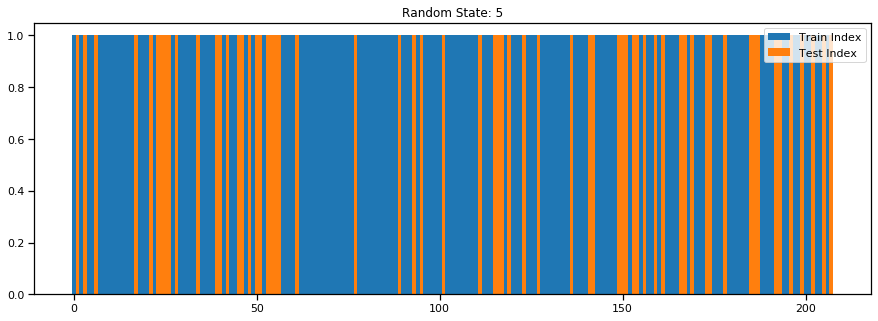

In [12]:
from sklearn.model_selection import train_test_split

random_state = 5
index_train, index_test = train_test_split(data.index, train_size=0.7, random_state=random_state)

fig = plt.figure(figsize = (15, 5))
plt.bar(index_train, np.ones(len(index_train)), label='Train Index', width=1)
plt.bar(index_test, np.ones(len(index_test)), label='Test Index', width=1)
plt.title(f'Random State: {random_state}')

plt.legend();

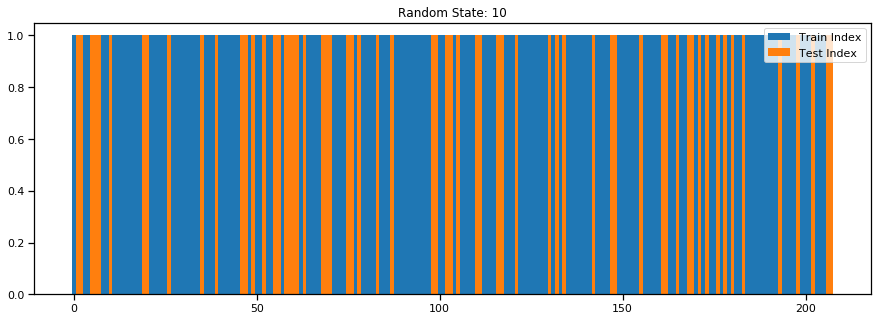

In [25]:
from sklearn.model_selection import train_test_split

random_state = 10
index_train, index_test = train_test_split(data.index, train_size=0.7, random_state=random_state)

fig = plt.figure(figsize = (15, 5))
plt.bar(index_train, np.ones(len(index_train)), label='Train Index', width=1)
plt.bar(index_test, np.ones(len(index_test)), label='Test Index', width=1)
plt.title(f'Random State: {random_state}')

plt.legend();

In [26]:
sns.set_style('ticks')

In [27]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test = train_test_split(np.array(data.index), train_size=0.7, random_state=10)

# Write training and test sets 
train = data.loc[index_train, :].copy()
test =  data.loc[index_test, :].copy()  # the copy here is for technical reasons

train.head()

,Gender,Experience,Salary
24,Female,11,70800
43,Female,9,59600
144,Male,7,53400
21,Female,18,68000
129,Female,15,102400


## Exploratory Data Analysis

Exploratory data analysis (EDA) is the process of discovering features and patterns in the data that should inform the modelling process and, in some cases, prevent errors. Here we conduct a short EDA of the dataset. Remember that we should use only the training set for this purpose. 

The next several cells display a range of summary measures and exploratory plots for the data. We learn for example that: 

* On average, male employees have higher salaries than female employees. The pay gap seems to be larger at the upper quantiles of the salary distribution for each group.  The variance in salaries is substantially higher for males.

 
* The distribution of salary is clearly right skewed for both males and females.


* Not surprisingly, experience is strongly positively related with salary. When considering all the employees, three of them appear to be outliers as they have much higher salaries than the rest. These are probably senior executives in the company (further investigation would reveal that they are all males). 


* There seems to be an interaction between gender and experience. The pay gap increases with the level of experience. Allowing for this interaction, the employees with highest salaries do not seem to be outliers anymore.

In [16]:
train['Gender'].unique()

array(['Female', 'Male'], dtype=object)

The code below is actually quite difficult to understand, and I barely understand how it works. But, this is of no issue, we just need to learn how to read it. So going part by part

    train.groupby('Gender') - Group the training data by the Gender column. When we look at the unique values in the Gender column, we see that we have Female and Male. So what this code does is that it splits it into 1 dataset that only contains the Female, and 1 dataset that only contains Male
    
    train.groupby('Gender')['Salary'] - Once you group it, only look at the Salary column
    
    train.groupby('Gender')['Salary'].describe() - Then describe the data
    
    train.groupby('Gender')['Salary'].describe().round(2) - Then Round it to 2 d.p.

In [17]:
train.groupby('Gender')['Salary'].describe().round(2)  # round the results to two decimal places

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,97.0,75034.85,13573.05,54000.0,65480.0,72800.0,82800.0,123600.0
Male,48.0,90211.25,30172.77,53400.0,69130.0,85000.0,97250.0,194000.0


For this code

    sns - We will be using sns (or seaborn) to make our boxplot. Now you can use anything you wish, but here we will be using seaborn
    
    sns.boxplot - Clearly we are going to be making a boxplot, and importantly, we will be using sns to create it. The way we know that we are using sns is because of the . - meaning that we are going in another level of our library
    
    sns.boxplot(x='Gender', y='Salary', data=train - The x-axis is going to be the Gender column and the y-axis is going to be Salary.
    
    sns.boxplot(x='Gender', y='Salary', data=train, palette='Blues') - Palette meaning the range of colours used in a particular picture. So here we will be using a blue palette
    
    
Also notice how a box plot for the different categories is automatically created, we didn't need to specify that in the code - it does it for us. 

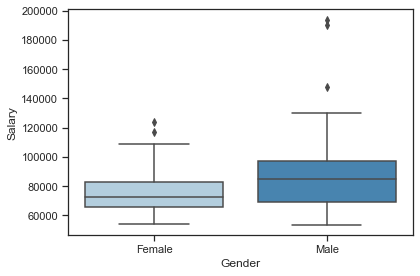

In [18]:
sns.boxplot(x='Gender', y='Salary', data=train, palette='Blues')
plt.tight_layout()
plt.show()

In [19]:
data.columns

Index(['Gender', 'Experience', 'Salary'], dtype='object')

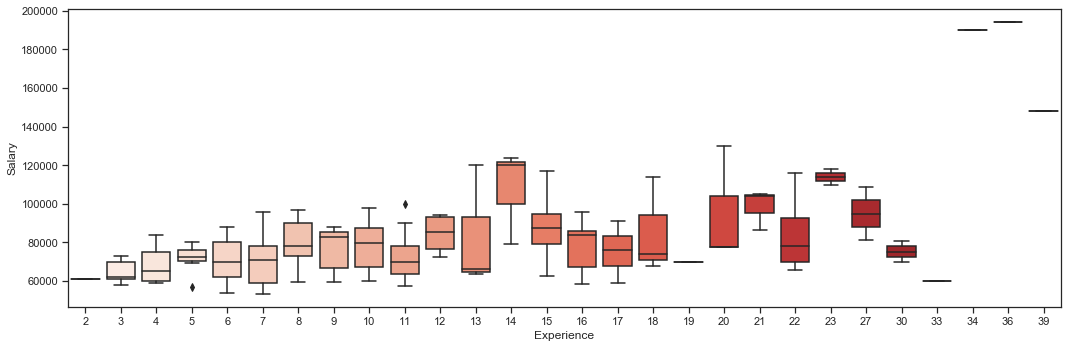

In [29]:
fig = plt.figure(figsize = (15, 5))
sns.boxplot(x='Experience', y='Salary', data=train, palette='Reds')
plt.tight_layout()
plt.show()

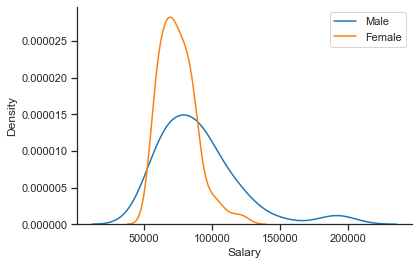

In [30]:
sns.distplot(train.loc[train['Gender']=='Male', 'Salary'], hist=False, label='Male')
sns.distplot(train.loc[train['Gender']=='Female', 'Salary'], hist=False, label='Female')
sns.despine()
plt.legend();
plt.show()

### `sns.regplot(train['Experience'], train['Salary'], scatter_kws={'s': 30}, ci=None)`

    sns.regplot(train['Experience'], train['Salary'] - usually when you are plotting in python, the x-values will always go first, and the y-values last. In this case, the x-values we want is the Experience column and the y-values we want is Salary.
    
    sns.regplot(train['Experience'], train['Salary'], scatter_kws={'s': 30}, - scatter_kws stands for scatter-keyword arguments, meaning that {'s': 30} is the arguments for the scatter dots. Basically, it will determine how the scatter dots will look like. So in this case 's' (aka the size) will be equal to 30.
    
    sns.regplot(train['Experience'], train['Salary'], scatter_kws={'s': 30}, ci=None) - ci stands for confidence interval of the regression plot

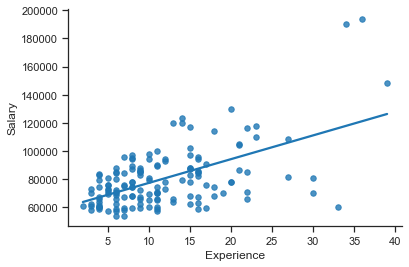

In [34]:
sns.regplot(train['Experience'], train['Salary'], scatter_kws={'s': 30}, ci=None)
sns.despine()
plt.show()

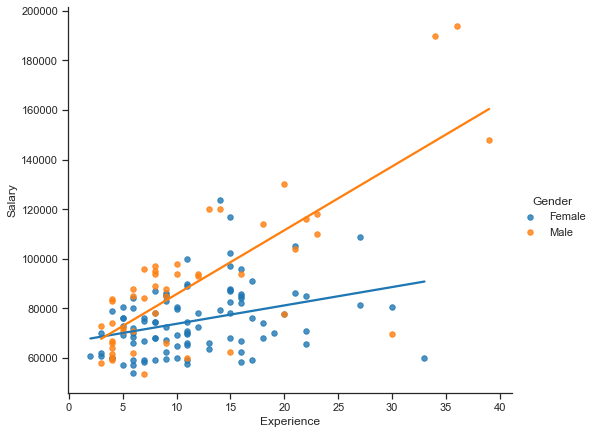

In [23]:
# Notice the new thing now is hue='Gender', so this is how you get
# two different regression plots
sns.lmplot('Experience', 'Salary', data=train, hue='Gender', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

## Data Preparation

In most cases, we need to perform additional processing to get the data ready for training machine learning models and computing predictions. It is good practice to write a function for this step.

Below we create a dummy valiable in order to incorporate the gender predictor into the regression.

In [24]:
train.head()

,Gender,Experience,Salary
24,Female,11,70800
43,Female,9,59600
144,Male,7,53400
21,Female,18,68000
129,Female,15,102400


In [35]:
def prepare_data(df):
    """ Given a pd.DataFrame, returns a pd.DataFrame where the 'Female' column
        is encoded as 
            1 - If 'Gender' == 'Female'
            0 - Otherwise
    
        Parameters
        ----------
        df : pd.DataFrame
            Assumed to have a column named 'Gender'
            
        Returns
        -------
        pd.DataFrame
    """
    # create dummy variable for gender (last part converts True/F to 1/0)
    df['Female'] = (df['Gender'] == 'Female').astype(int) 
    return df


train = prepare_data(train)
test = prepare_data(test)

train.head()

,Gender,Experience,Salary,Female
24,Female,11,70800,1
43,Female,9,59600,1
144,Male,7,53400,0
21,Female,18,68000,1
129,Female,15,102400,1


`df['Female'] = (df['Gender'] == 'Female').astype(int)` to understand this code, it's easy! You just need to know how to read it, once again. 

    df['Gender'] == 'Female' - So we are just going to check if the Gender column is equal to Female. If it is equal to Femail then we get a True, if not we get a False
    
    (df['Gender'] == 'Female').astype(int) - When df['Gender'] == 'Female' is performed we get True and False values. But, now we say we want it as type integer - meaning that we now want the values as the type int.
    
    df['Female'] = (df['Gender'] == 'Female').astype(int) - df at the column Female is then set to this value

In [26]:
(train['Gender'] == 'Female').head()  # Just checking if the Gender column is equal to Female

24      True
43      True
144    False
21      True
129     True
Name: Gender, dtype: bool

In [27]:
# Now we want the True/False values to be as type int(eger)
(train['Gender'] == 'Female').astype(int).head()  

24     1
43     1
144    0
21     1
129    1
Name: Gender, dtype: int64

Creating other types of variables is easy. We know that salaries tend to increase in percentage terms every year, so that it is plausible that the relationship between salary and experience may be better described as a log-linear relationship. The log transformation may also help to reduce the positive skewness that we found in the EDA. 

## Linear Regression

There are several ways to estimate a linear regresssion in Python. In this tutorial, we use the statmodels package, as it generates [more informative](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html) outputs and results.

In [28]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='Salary ~ Female + Experience', data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     52.64
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           7.86e-18
Time:                        11:48:44   Log-Likelihood:                -1612.9
No. Observations:                 145   AIC:                             3232.
Df Residuals:                     142   BIC:                             3241.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.04e+04   3275.348     21.494      0.0

### `ols = smf.ols(formula='Salary ~ Female + Experience', data=train).fit()`

So here we have just built out first model. It is also very clear what we are doing

    smf.ols - We are going to be building an ols model
    
    smf.ols(formula='Salary ~ Female + Experience' - Our regression formula. The output variable is Salary, and the 2 input variables is Female and Experience
    
    smf.ols(formula='Salary ~ Female + Experience', data=train) - The dataset that we will train the model on is simply train
    
    smf.ols(formula='Salary ~ Female + Experience', data=train).fit() - Then we fit the model, and save it to ols

In [36]:
import statsmodels.formula.api as smf

formula = 'Salary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     52.64
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           7.86e-18
Time:                        19:36:42   Log-Likelihood:                -1612.9
No. Observations:                 145   AIC:                             3232.
Df Residuals:                     142   BIC:                             3241.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.04e+04   3275.348     21.494      0.0

The output is difficult to read because of the scale of the salary variable.  We can improve it by expressing the salary in thousands.  Using the formula approach makes it easier to transform variables for purposes of estimating the regression. 

In [30]:
formula = 'np.divide(Salary, 1000) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                               OLS Regression Results                              
Dep. Variable:     np.divide(Salary, 1000)   R-squared:                       0.426
Model:                                 OLS   Adj. R-squared:                  0.418
Method:                      Least Squares   F-statistic:                     52.64
Date:                     Thu, 18 Mar 2021   Prob (F-statistic):           7.86e-18
Time:                             11:48:44   Log-Likelihood:                -611.30
No. Observations:                      145   AIC:                             1229.
Df Residuals:                          142   BIC:                             1238.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

<hr style="height:2px;border-width:0;color:black;background-color:black">

I'd be willing to bet, some of you are asking how did we know to write `'np.divide(Salary, 1000) ~ Female + Experience'` instead of the more obvious `'Salary/1000 ~ Female + Experience'`. Turns out the last way gives us an error.

No threat, as I said earlier, it is only in this week that we will be using `smf`. Later weeks we will be using something far more easier than `smf` so don't worry about this too much.

In [83]:
formula = 'Salary/1000 ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

PatsyError: numbers besides '0' and '1' are only allowed with **
    Salary/1000 ~ Female + Experience
           ^^^^

<hr style="height:2px;border-width:0;color:black;background-color:red">

If were compare a male and female employee with the same level of experience, we would expect the female employee to earn 15.1K less according to this estimate (note: coefficients depend on the random split into training and test data, so you might get different values). The coefficient for the Female variable is statistically significant, so that we can reliably conclude that the female employees have lower salaries on average controlling for experience. 

Is this model appropriate for the data? We should use residual diagnostics to check. The diagnostic plot below reveals a nonlinear pattern in the residuals, which means that the linear specification is not correct for this data. We should try to improve the model by considering a log transformation (suggested by domain knowledge and EDA) and an interaction term (suggested by EDA). 

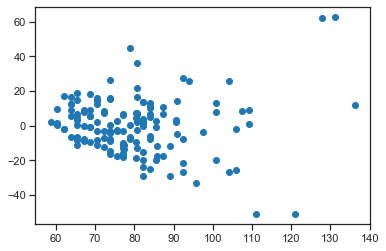

In [31]:
plt.scatter(ols.fittedvalues, ols.resid)

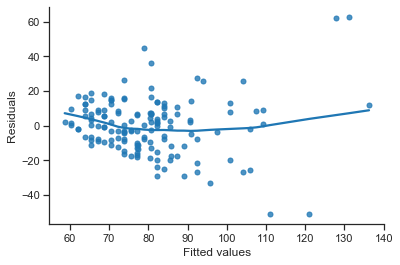

In [32]:
fig, ax= plt.subplots()

# Note that we are getting the fitted values and the residuals from the regression results here
# The lowess option fits a nonparametric regression to the scatter plot, allowing us to visualise 
# possible nonlinear patterns

# lowess stands for locally weighted linear regression, essentially we are going to perform linear
# regression in small portions of the dataset

sns.regplot(ols.fittedvalues, ols.resid, scatter_kws={'s': 25}, lowess=True, ax=ax) 
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.show()

Interpret the two models below (especially the coefficients). Note that the second model includes a an interaction term (for gender and experience).

In [33]:
formula = 'np.log(Salary) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(Salary)   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     42.90
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           2.67e-15
Time:                        11:48:44   Log-Likelihood:                 41.754
No. Observations:                 145   AIC:                            -77.51
Df Residuals:                     142   BIC:                            -68.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1676      0.036    308.103      0.0

In [34]:
formula = 'np.log(Salary) ~ Female + Experience + Experience:Female'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(Salary)   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     35.06
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           5.42e-17
Time:                        11:48:44   Log-Likelihood:                 47.894
No. Observations:                 145   AIC:                            -87.79
Df Residuals:                     141   BIC:                            -75.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.0863      0.04

We can check that this last specification improves the residuals.

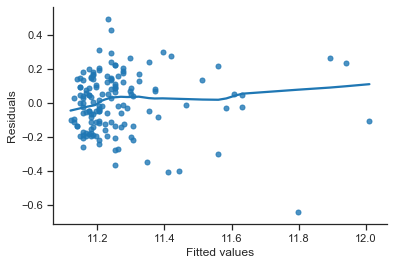

In [35]:
fig, ax= plt.subplots()
sns.regplot(ols.fittedvalues, ols.resid, scatter_kws={'s': 25}, lowess=True, ax=ax)
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.show()






## Model Evaluation

We now compare different specifications on the test data. Note that for the models with a log transformed response, we use an appropriate retransformation and an adjustment when computing the predictions for salary. 

We should be careful with our analysis since there are not many test cases. Here are some tentative conclusions. 

* The models with an interaction term predict better than the ones without.


* When comparing the two models with the interaction term, the log model has slightly better predictive ability.

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [55]:
rmse_of_models = []  # Create an empty list (or bag) to store the rmse and r2 scores
r2_of_models = []

**Model 1: `Salary ~ Female + Experience`**

In [56]:
# Model 1
formula = 'Salary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()  # run the ols model
predictions = ols.predict(test)  # use the model to make predictions on the test data 

rmse = np.sqrt(mean_squared_error(test['Salary'], predictions))
r2 = r2_score(test['Salary'], predictions)

print('RMSE: ', rmse)
print('R2: ', r2)

rmse_of_models.append(rmse)  # append (or add) the rmse to the list
r2_of_models.append(r2)

RMSE:  17795.955719248766
R2:  0.4609950084808083


**Model 2: `Salary ~ Female + Experience + Experience:Female`**

In [57]:
# Model 2
formula = 'Salary ~ Female + Experience + Experience:Female'
ols = smf.ols(formula=formula, data=train).fit()
predictions = ols.predict(test)

rmse = np.sqrt(mean_squared_error(test['Salary'], predictions))
r2 = r2_score(test['Salary'], predictions)

print('RMSE: ', rmse)
print('R2: ', r2)

rmse_of_models.append(rmse)
r2_of_models.append(r2)

RMSE:  15052.05255213154
R2:  0.6143959328125486


**Model 3: `np.log(Salary) ~ Female + Experience`**

With this model we have to be a bit careful. In this model we are not actually modeling `Salary`, instead we are actually modeling `log(Salary)`. As such, we need to convert it back into `Salary` by taking the exponential of our predictions.

Also note that because we are modeling `log(Salary)` our model becomes biased (see Lecture 2 Pg 34-35). To fix that, we need to do

$$\hat{Y}=\exp\left(\hat{\beta}_0 + \hat{\beta}_1x_1 + \cdots \hat{\beta}_px_p\right)\left[\frac{1}{n}\sum^n_{i=1}\exp(e_i)\right]$$

That is we need to multiply our predictions by the average of the exponential of all the residuals.

In [58]:
# Model 3
formula = 'np.log(Salary) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()

log_of_predictions = ols.predict(test)
predictions = np.exp(log_of_predictions)*np.mean(np.exp(ols.resid))  # Bias correction

rmse = np.sqrt(mean_squared_error(test['Salary'], predictions))
r2 = r2_score(test['Salary'], predictions)

print('RMSE: ', rmse)
print('R2: ', r2)

rmse_of_models.append(rmse)
r2_of_models.append(r2)

RMSE:  17337.794799176012
R2:  0.48839135870900907


**Model 4: `np.log(Salary) ~ Female + Experience + Experience:Female`**

In [59]:
# Model 4
formula = 'np.log(Salary) ~ Female + Experience + Experience:Female'
ols = smf.ols(formula=formula, data=train).fit()

log_of_predictions = ols.predict(test)
predictions = np.exp(log_of_predictions)*np.mean(np.exp(ols.resid))

rmse = np.sqrt(mean_squared_error(test['Salary'], predictions))
r2 = r2_score(test['Salary'], predictions)

print('RMSE: ', rmse)
print('R2: ', r2)

rmse_of_models.append(rmse)
r2_of_models.append(r2)

RMSE:  14851.047546938707
R2:  0.6246258764423067


In [64]:
print('rmse_of_models: ', rmse_of_models)
print('----------------------------------------')
print('r2_of_models: ', r2_of_models)

rmse_of_models:  [17795.955719248766, 15052.05255213154, 17337.794799176012, 14851.047546938707]
----------------------------------------
r2_of_models:  [0.4609950084808083, 0.6143959328125486, 0.48839135870900907, 0.6246258764423067]


In [61]:
columns = ['RMSE', 'R-Squared']
rows = ['Base Model',  'Interaction', 'Log Transform', 'Log Transform + Interaction']

# Create a dataframe with the column names as columns and index names as rows
# The 0.0 means that we are just going to set all the values in the dataframe to 0.0
results = pd.DataFrame(0.0, columns=columns, index=rows)  

results

,RMSE,R-Squared
Base Model,0.0,0.0
Interaction,0.0,0.0
Log Transform,0.0,0.0
Log Transform + Interaction,0.0,0.0


In [63]:
# Fill out the table
for i in range(4):
    results.iloc[i, 0] = rmse_of_models[i]
    results.iloc[i, 1] = r2_of_models[i]
    
results.round(2)

,RMSE,R-Squared
Base Model,17795.96,0.46
Interaction,15052.05,0.61
Log Transform,17337.79,0.49
Log Transform + Interaction,14851.05,0.62


# Lecture 3 Summary

### K-Nearest Neighbours
So this is the next model that we have learnt, after linear regression. The idea is very simple, suppose our dataset is $(X, Y)$. Then if we want to make a prediction at $x_0$, all we need to do is find the $k$-closest datapoints in $X$ and just take the average of the output.

So here we are doing classification, and we want to classify this new green dot into either the orange or blue class. So all you need to do is to look at the closest points and make our judgements on the $k$ (in this case $k=3$) nearest neighbours.
<img align="center" src="https://www.kdnuggets.com/wp-content/uploads/rapidminer-knn-image1.jpg" width='450'>

But a question, that you may not realise is, how do you determine if a datapoint is closer than each other. So to do that, you need a nototion of distance. A simple example is the manhatten (or taxi-cab) distance and the euclidian distance.

$$\textrm{Euclid}(\mathbf{p}, \mathbf{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2}$$
$$\textrm{Manhatten}(\mathbf{p}, \mathbf{q}) = |p_1 - q_1| + |p_2 - q_2|$$

<img align="center" src="https://qph.fs.quoracdn.net/main-qimg-8d64c8344fc8364e46b9712e2c51dca4.webp">

    Fun fact about the Manhatten distance, this is named after the city of Manhatten and used to describe how many streets you need to move from one point to another. Also, turns out, that such a city design isn't actually very good. Cities with grid like streets actually create wind tunnels, because of all the straight roads (which is why it is really windy in Melbourne). But if you have more curvey streets the wind actually breaks on the curves, hence reduce the amount of wind.

Taking the points $x_1=(0,0); x_2=(5, 4); x_3=(7, 1)$. Let us see which point is closer to $x_1$ using the 2 different metrics.

$$\textrm{Euclid}(x_1, x_2)=\sqrt{(5-0)^2 + (4-0)^2} \approx 6.4;\quad \textrm{Euclid}(x_1, x_3)=\sqrt{(7-0)^2 + (1-0)^2} \approx 7.07$$

$$\textrm{Manhatten}(x_1, x_2) = (5 - 0) + (4 - 0) = 9;\quad \textrm{Manhatten}(x_1, x_3) = (7 - 0) + (1 - 0) = 8$$

<b> Don't worry about the code below. It is more advanced than you will ever need to be for this course</b>

In [44]:
import matplotlib.pyplot as plt

In [45]:
def euclid(x1, x2):
    x1, x2 = np.array(x1), np.array(x2)
    return np.sqrt(np.sum((x1 - x2)**2))

def manhatten(x1, x2):
    x1, x2 = np.array(x1), np.array(x2)
    return np.sum(abs(x1 - x2))

def plot_euclid(x1, x2):
    x_vals = [x1[0], x2[0]]
    y_vals = [x1[1], x2[1]]
    plt.plot(x_vals, y_vals, label=f'Euclid={format(euclid(x1, x2), ".2f")}')
    
def plot_manhatten(x1, x2):
    x_vals = [x1[0], x2[0], x2[0]]
    y_vals = [x1[1], x1[1], x2[1]]
    plt.plot(x_vals, y_vals, label=f'Manhatten={format(manhatten(x1, x2), ".2f")}')

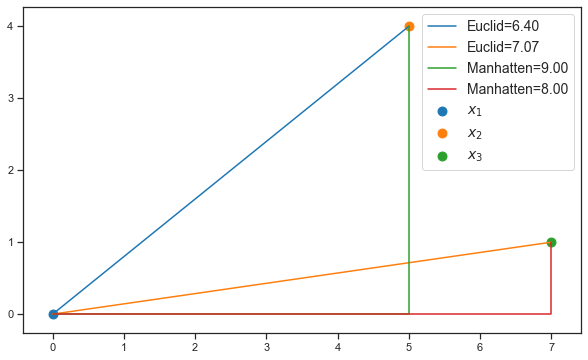

In [46]:
plt.figure(figsize = (10, 6))
x1, x2, x3 = (0, 0), (5, 4), (7, 1)

plot_euclid(x1, x2)
plot_euclid(x1, x3)

plot_manhatten(x1, x2)
plot_manhatten(x1, x3)

for i, x in enumerate([x1, x2, x3], 1): 
    plt.scatter(*x, label=f'$x_{i}$', s=80)

plt.legend(prop={'size': 14});

Curious! Using the Euclidian distance, you get that $x_2$ is closer than $x_3$. But, in the Manhatten distance you get the opposite ($x_3$ is closer than $x_2$). As such, different metrics will actually have different points in the neighbourhood, therefore giving different predictions. 

So this is the reason why you need to be careful with which metric you use, and using a different metric can give better results than using the other.

Now, I hear you say, well which metric should I use? Now varients of this question will always come up in these tutorials
- Which model is better
- Is it better if I used a different transformation on the dataset
- Which encoding of the categorial variables is best,
- etc.

The answer to all of them is, I don't know, just try and see what happens. So just try using different metrics, and see which metric works the best. Then just choose the metric that works the best. Now the reason why I say this is because different methods will work differently on different datasets. As such, there never really is 'the best method'. But there is a best method for the specific dataset you are working on, and you will need to find this through running experiments.

<hr style="height:2px;border-width:0;color:black;background-color:black">

### A Warning When Modeling
In the real world, if you are not careful with the input variables you use, you can get into real trouble.

When you do life modeling (modeling when people will die) for insurance reasons, it is a rule that you cannot use one's gender nor their ethnicity as modeling predictors. Eventhough these predictors may have high correlation with their life expectancy, it is a big no-no because 

    He missed the point. In mathematics and science, there is no difference in the intelligence of men and women. The difference in genes between men and women is simply the Y chromosome, which has nothing to do with intelligence.
    - Dr Christiane Nüsslein-Volhard, the 1995 Nobel laureate in physiology and medicine
    
In the same sense, when we are trying to model one's salary we should be very careful in what we want our model to do. If we simply want to use our model to observe casual relationships (think correlation), then using these no-no predictors can be okay. But, if we are trying to use the model to make predictions on future data, or make causal inferences (think causation) then it is highly inappropriate to use these predictors.

Taken from [The Most Dangerous Equation](https://www.americanscientist.org/article/the-most-dangerous-equation#:~:text=The%20obvious%20winner%20in%20this,the%20construction%20of%20atomic%20bombs) by Howard Wainer:

    The familiar linear regression equation contains many pitfalls to trap the unwary. The correlation coefficient that emerges from regression tells us about the strength of the linear relation between the dependent and independent variables. But alas it encourages fallacious attributions of cause and effect. It even encourages fallacious interpretation by those who think they are being careful. ("I may not be able to believe the exact value of the coefficient, but surely I can use its sign to tell whether increasing the variable will increase or decrease the answer.") The linear regression equation is also badly non-robust, but its weaknesses are rarely diagnosed appropriately, so many models are misleading. When regression is applied to observational data (as it almost always is), it is difficult to know whether an appropriate set of predictors has been selected—and if we have an inappropriate set, our interpretations are questionable. It is dangerous, ironically, because it can be the most useful model for the widest variety of data when wielded with caution, wisdom and much interaction between the analyst and the computer program.
    - Howard Wainer, The Most Dangerous Equation
  
  
For this class, we are usually not that careful with using taboo predictors. The main reason being that we are not trying to make statements about the world. Perhaps this is me being naive, but out main focus is for the students to understand the different models that will be taught in this course. The easiest way to do so is by building them, which is what we will do in this course.

<hr style="height:2px;border-width:0;color:black;background-color:red">